# Machine Learning

In [1]:
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [3]:
import spacy

# Load SpaCy model for lemmatization
#spacy.require_gpu()
NLP = spacy.load("en_core_web_trf")

/home/abe/nlp-sentiment-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# load environment variables
load_dotenv()

path = os.getenv("DATA_FOLDER")
if path is None:
    raise ValueError("Environment variable 'DATA_FOLDER' is not set.")

In [5]:
names = ["tweet_id", "entity", "sentiment", "text"]
train_df = pd.read_csv(filepath_or_buffer=path + "/twitter_training.csv", names=names)
val_df = pd.read_csv(filepath_or_buffer=path + "/twitter_validation.csv", names=names)

In [6]:
train_df

,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [7]:
val_df

,tweet_id,entity,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [8]:
train_df.sentiment.value_counts()

sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [9]:
val_df.sentiment.value_counts()

sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

## Preprocessing

In [10]:
def preprocess_text(text, lemmatize=False):
    """
    Cleans, preprocesses and lemmatizes text by removing special characters, converting to lowercase and removing extra space

    Args:
        text (str): input text

    Returns:
        text(str): cleaned and preprocessed text
    """
    # Clean text
    text = re.sub(r"http\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"\S+@\S+\.\S+", "", text)  # Remove emails
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces

    # Lemmatize text using SpaCy
    doc = NLP(text)

    if lemmatize:
        text = " ".join(
            token.lemma_ for token in doc if token.is_alpha and not token.is_stop
        )

    else:
        text = " ".join(
            token.text for token in doc if token.is_alpha and not token.is_punct
        )

    return text

In [11]:
train_df["preprocessed_text"] = (
    train_df["text"].astype(str).apply(lambda x: preprocess_text(x, lemmatize=True))
)
val_df["preprocessed_text"] = (
    val_df["text"].astype(str).apply(lambda x: preprocess_text(x, lemmatize=True))
)

We need to inject the entity into the text input

In [12]:
# Add the entity with a message
train_df["input_text"] = train_df.apply(
    lambda row: f"What is the sentiment about {row['entity']} in: {row['preprocessed_text']}",
    axis=1,
)
val_df["input_text"] = val_df.apply(
    lambda row: f"What is the sentiment about {row['entity']} in: {row['preprocessed_text']}",
    axis=1,
)

In [13]:
train_df

,tweet_id,entity,sentiment,text,preprocessed_text,input_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,m get borderland murder,What is the sentiment about Borderlands in: m ...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,What is the sentiment about Borderlands in: co...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,m get borderland kill,What is the sentiment about Borderlands in: m ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,m come borderland murder,What is the sentiment about Borderlands in: m ...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,m get borderland murder,What is the sentiment about Borderlands in: m ...
...,...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realize windows partition mac like year nvidia...,What is the sentiment about Nvidia in: realize...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realize mac window partition year nvidia drive...,What is the sentiment about Nvidia in: realize...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realize windows partition mac year nvidia driv...,What is the sentiment about Nvidia in: realize...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,realize window partition mac like year nvidia ...,What is the sentiment about Nvidia in: realize...


In [14]:
# Drop duplicates and nulls
train_dedup = train_df.drop_duplicates()
null_texts = train_dedup[train_dedup.text.duplicated(keep=False)].index
train = train_dedup.drop(index=null_texts)

In [15]:
val_dedup = val_df.drop_duplicates()
null_texts = val_dedup[val_dedup.text.duplicated(keep=False)].index
val = val_dedup.drop(index=null_texts)

In [16]:
train_df = train.copy()
val_df = val.copy()

In [17]:
# Replace the Irrelevant for Neutral (as per the instructions from Kaggle: "We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral")

train_df["sentiment"] = train_df["sentiment"].replace("Irrelevant", "Neutral")
val_df["sentiment"] = val_df["sentiment"].replace("Irrelevant", "Neutral")

In [18]:
# We encode the targets
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(train_df["sentiment"])
y_val = lb.transform(val_df["sentiment"])

In [19]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [20]:
val_df.head()

,tweet_id,entity,sentiment,text,preprocessed_text,input_text
0,3364,Facebook,Neutral,I mentioned on Facebook that I was struggling ...,mention facebook struggle motivation run day t...,What is the sentiment about Facebook in: menti...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos reject claim c...,What is the sentiment about Amazon in: bbc new...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,microsoft pay word function poorly samsungus c...,What is the sentiment about Microsoft in: micr...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking closet hacking truly awful game,What is the sentiment about CS-GO in: csgo mat...
4,4433,Google,Neutral,Now the President is slapping Americans in the...,president slap americans face commit unlawful ...,What is the sentiment about Google in: preside...


## Prediction

### with TF-IDF encoding

In [21]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=None,
    max_df=0.25,  # Relaxed filtering
    ngram_range=(1, 2),  # bigrams instead of unigrams
    stop_words="english",
    token_pattern=r"([a-zA-Z0-9-/]{2,})",
)
X_train = tfidf_vectorizer.fit_transform(train_df["input_text"])
X_val = tfidf_vectorizer.transform(val_df["input_text"])

Let's try using a OneVsRest schema:

In [22]:
clf = OneVsRestClassifier(
    LogisticRegression(random_state=42),
    n_jobs=-1,
)

clf.fit(X_train, y_train)

,estimator,LogisticRegre...ndom_state=42)
,n_jobs,-1
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42


In [23]:
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.8536620613908319

In [24]:
y_val_pred = clf.predict(X_val)
accuracy_score(y_val, y_val_pred)

0.9198396793587175

Now let's try an ensemble method like Random Forest:

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42)

forest_clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
y_train_pred = forest_clf.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9944360945719406

In [27]:
y_val_pred = forest_clf.predict(X_val)
accuracy_score(y_val, y_val_pred)

0.9789579158316634

In [28]:
# Save the model
import joblib

joblib.dump(forest_clf, "forest_clf.pkl")

['forest_clf.pkl']

Results are really impressive. Let's see if we can improve them using embeddings:

### with Embeddings

In [29]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # or any other model

X_train = embedding_model.encode(
    train["preprocessed_text"].tolist(), convert_to_tensor=False
)
X_val = embedding_model.encode(
    val["preprocessed_text"].tolist(), convert_to_tensor=False
)

2025-08-26 11:30:01.315093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 11:30:01.479507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756200601.537101    5390 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756200601.552426    5390 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756200601.695981    5390 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [30]:
forest_clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
y_train_pred = forest_clf.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9913145268512631

In [32]:
y_val_pred = forest_clf.predict(X_val)
accuracy_score(y_val, y_val_pred)

0.8486973947895792

Not really improving here. For now the TF-IDF+RandomForestClassifier is our best performer. Lets test with Deep Learning models:

# Deep Learning

## TFIDF

In [33]:
names = ["tweet_id", "entity", "sentiment", "text"]
train_df = pd.read_csv(filepath_or_buffer=path + "/twitter_training.csv", names=names)
val_df = pd.read_csv(filepath_or_buffer=path + "/twitter_validation.csv", names=names)

In [34]:
average_word_count = (
    train_df["text"].dropna().apply(lambda x: len(str(x).split())).mean()
)

print(f"Average number of words: {average_word_count:.2f}")

Average number of words: 19.23


In [35]:
train_df.head()

,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [36]:
train_df.sentiment.value_counts()

sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [37]:
val_df.sentiment.value_counts()

sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

In [38]:
label_to_int = {"Negative": 0, "Neutral": 1, "Irrelevant": 1, "Positive": 2}
train_df["label"] = train_df["sentiment"].map(label_to_int)
val_df["label"] = val_df["sentiment"].map(label_to_int)

Now we want to have the text including the entity, in the same format as before: "What is the sentiment about [ENTITY] in: [TEXT]"

In [39]:
train_df["input_text"] = train_df.apply(
    lambda row: f"What is the sentiment about [ENTITY] <e>{row['entity']}</e> in: {row['text']}",
    axis=1,
)

In [40]:
val_df["input_text"] = val_df.apply(
    lambda row: f"What is the sentiment about [ENTITY] <e>{row['entity']}</e> in: {row['text']}",
    axis=1,
)

In [41]:
train_df.head()

,tweet_id,entity,sentiment,text,label,input_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,2,What is the sentiment about [ENTITY] <e>Border...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2,What is the sentiment about [ENTITY] <e>Border...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2,What is the sentiment about [ENTITY] <e>Border...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2,What is the sentiment about [ENTITY] <e>Border...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2,What is the sentiment about [ENTITY] <e>Border...


In [42]:
train_texts = train_df["input_text"].values
train_labels = train_df["label"].values

In [43]:
val_texts = val_df["input_text"].values
val_labels = val_df["label"].values

In [44]:
from tensorflow.keras.layers import TextVectorization

text_vectorization_tfidf = TextVectorization(
    ngrams=2, max_tokens=10000, output_mode="tf_idf"
)

I0000 00:00:1756200635.157762    5390 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13179 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [45]:
# It may sometimes crash the kernel!!
text_vectorization_tfidf.adapt(train_texts)

In [46]:
import tensorflow as tf

X_train = text_vectorization_tfidf(train_texts)
X_val = text_vectorization_tfidf(val_texts)

# Convert to tf.data.Dataset
train_ds_tfidf = (
    tf.data.Dataset.from_tensor_slices((X_train, train_labels)).shuffle(1000).batch(32)
)
val_ds_tfidf = tf.data.Dataset.from_tensor_slices((X_val, val_labels)).batch(32)

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential(
    [Dense(64, activation="relu"), Dropout(0.3), Dense(3, activation="softmax")]
)

In [48]:
import keras

checkpoint_cb = keras.callbacks.ModelCheckpoint("tf-idf.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

callbacks = [checkpoint_cb, early_stopping_cb]

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(
    train_ds_tfidf, validation_data=val_ds_tfidf, epochs=30, callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1756200722.959871   36098 service.cc:152] XLA service 0x7f64ec01bce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756200722.960184   36098 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-08-26 11:32:03.012341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756200723.154202   36098 cuda_dnn.cc:529] Loaded cuDNN version 91002


  81/2334 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5652 - loss: 1.0406

I0000 00:00:1756200723.950685   36098 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2334/2334 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7421 - loss: 0.6339 - val_accuracy: 0.8320 - val_loss: 0.4390
Epoch 2/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8679 - loss: 0.3356 - val_accuracy: 0.9180 - val_loss: 0.2617
Epoch 3/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9162 - loss: 0.2169 - val_accuracy: 0.9200 - val_loss: 0.2174
Epoch 4/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9357 - loss: 0.1749 - val_accuracy: 0.9450 - val_loss: 0.1671
Epoch 5/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9440 - loss: 0.1435 - val_accuracy: 0.9530 - val_loss: 0.1374
Epoch 6/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9500 - loss: 0.1272 - val_accuracy: 0.9680 - val_loss: 0.1261
Epoch 7/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9543 - loss: 0.1159 - val_accuracy: 0.9680 - val_loss: 0.1265
Epoch 8/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9576 - loss: 0.1080 - val_accura

In [51]:
loss, acc = model.evaluate(val_ds_tfidf)
print(f"Validation Accuracy: {acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9780 - loss: 0.0931
Validation Accuracy: 0.9780


Let's save the model with the preprocessing layer included, so that it is capable of receiving raw text input:

In [52]:
from tensorflow.keras import Input, Model

# Create input layer that expects raw string input
inputs = Input(shape=(1,), dtype=tf.string)

# Apply text vectorization
x = text_vectorization_tfidf(inputs)

# Pass through the trained model (excluding input layer)
outputs = model(x)

# Create the full model
full_model_tf_idf = Model(inputs, outputs)

In [53]:
full_model_tf_idf.save("full_model_tf_idf.keras")

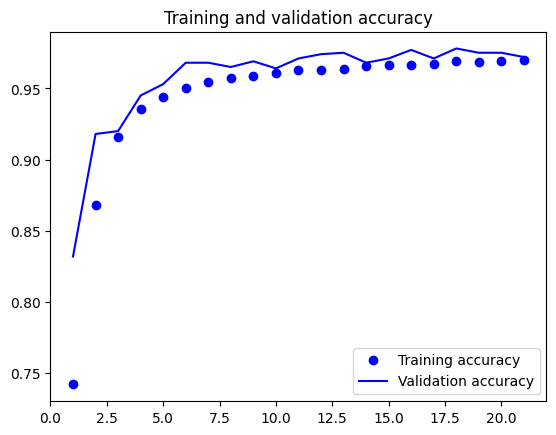

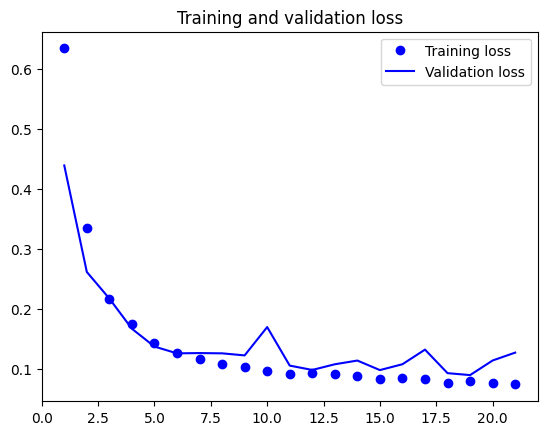

In [54]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


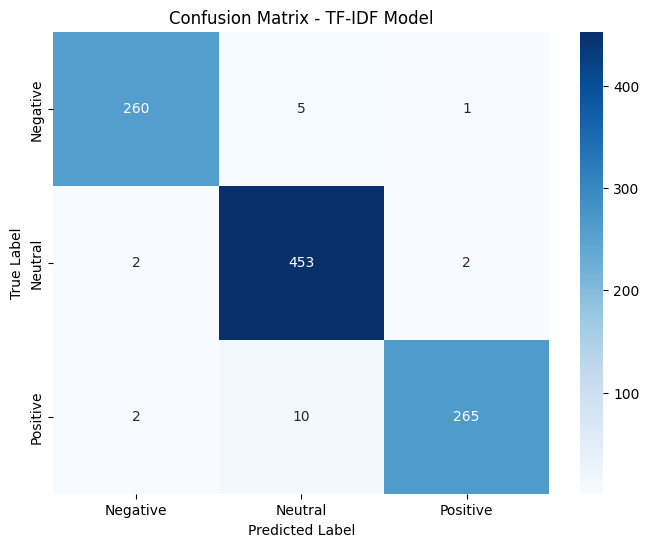

Classification Report - TF-IDF Model:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98       266
     Neutral       0.97      0.99      0.98       457
    Positive       0.99      0.96      0.97       277

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [56]:
# Generate predictions for confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions
y_val_pred = model.predict(val_ds_tfidf)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(val_labels, y_val_pred_classes)

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - TF-IDF Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("Classification Report - TF-IDF Model:")
print(classification_report(val_labels, y_val_pred_classes, 
                          target_names=['Negative', 'Neutral', 'Positive']))


## Embeddings

### 1D Convolutional

Let's try with a 1D convolutional network.

A sequence model will likely perform better because it makes use of embeddings

In [57]:
text_vectorization = TextVectorization(max_tokens=10000, output_sequence_length=64)

In [58]:
text_vectorization.adapt(train_texts)

In [59]:
# Vectorize
X_train = text_vectorization(train_texts)
X_val = text_vectorization(val_texts)

# Convert to tf.data.Dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, train_labels)).shuffle(1000).batch(32)
)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, val_labels)).batch(32)

In [60]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D

model = Sequential(
    [
        Embedding(input_dim=10000, output_dim=64, mask_zero=True),
        GlobalAveragePooling1D(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="softmax"),
    ]
)

In [61]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("1D_conv.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # or 'val_accuracy' if you prefer
    patience=5,
    restore_best_weights=True,
)

callbacks = [checkpoint_cb, early_stopping_cb]

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [62]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)

Epoch 1/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6832 - loss: 0.7361 - val_accuracy: 0.7920 - val_loss: 0.5202
Epoch 2/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7866 - loss: 0.5224 - val_accuracy: 0.8290 - val_loss: 0.4298
Epoch 3/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8196 - loss: 0.4371 - val_accuracy: 0.8590 - val_loss: 0.3585
Epoch 4/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8388 - loss: 0.3799 - val_accuracy: 0.8740 - val_loss: 0.3289
Epoch 5/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8550 - loss: 0.3371 - val_accuracy: 0.8770 - val_loss: 0.3040
Epoch 6/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8702 - loss: 0.3013 - val_accuracy: 0.8920 - val_loss: 0.2870
Epoch 7/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8820 - loss: 0.2711 - val_accuracy: 0.9040 - val_loss: 0.2831
Epoch 8/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8928 - loss: 0.2465 - 

In [64]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9570 - loss: 0.3293
Validation Accuracy: 0.9570


In [65]:
# Create input layer that expects raw string input
inputs = Input(shape=(1,), dtype=tf.string)

# Apply text vectorization
x = text_vectorization(inputs)

# Pass through the trained model (excluding input layer)
outputs = model(x)

# Create the full model
full_model_1D = Model(inputs, outputs)

In [66]:
full_model_1D.save("full_model_1D.keras")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


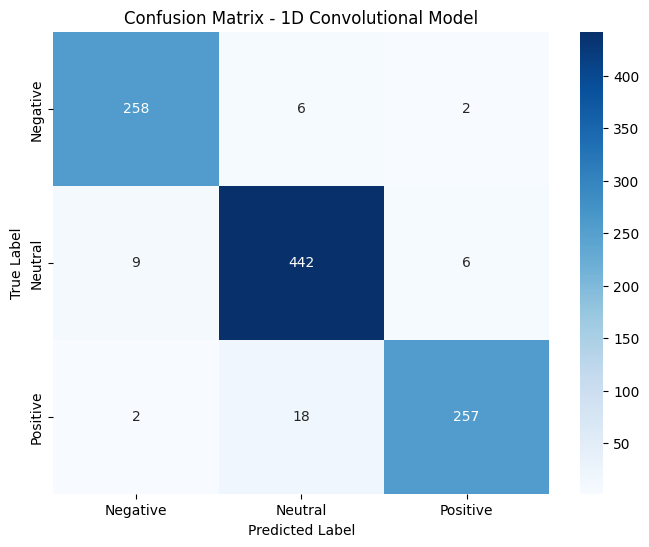

Classification Report - 1D Convolutional Model:
              precision    recall  f1-score   support

    Negative       0.96      0.97      0.96       266
     Neutral       0.95      0.97      0.96       457
    Positive       0.97      0.93      0.95       277

    accuracy                           0.96      1000
   macro avg       0.96      0.95      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [67]:
# Generate predictions for confusion matrix and classification report
y_val_pred = model.predict(val_ds)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(val_labels, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - 1D Convolutional Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("Classification Report - 1D Convolutional Model:")
print(classification_report(val_labels, y_val_pred_classes, 
                          target_names=['Negative', 'Neutral', 'Positive']))


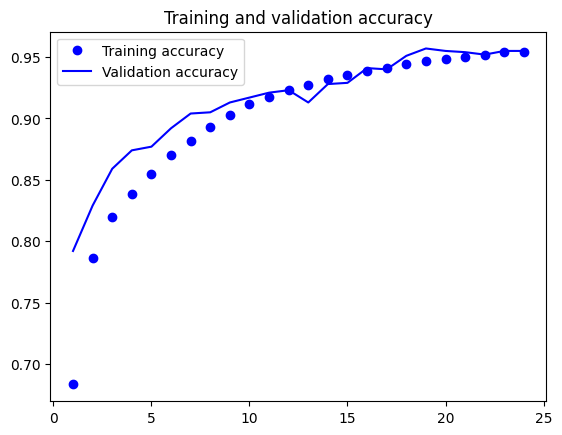

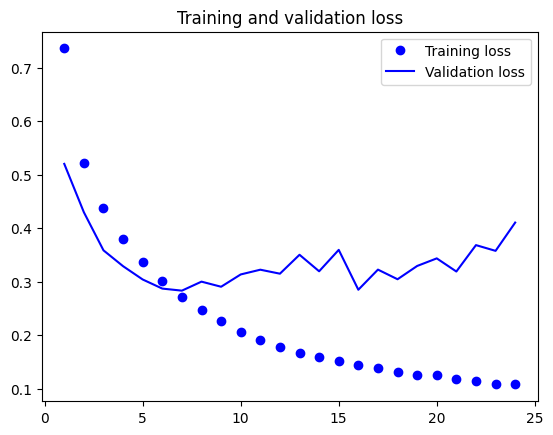

In [68]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

As we can see, validation loss didn't really change from epoch 8. As for validation accuracy: we had set early stopping and it prevent it to go further from epoch 25 (with a patience of 5)

Let's try a different approach changing the GlobalAveragePooling layer for a Bidirectional LSTM (GRU)

### GRU

In [69]:
from tensorflow.keras.layers import LSTM, Bidirectional

model = Sequential(
    [
        Embedding(input_dim=10000, output_dim=64, mask_zero=True),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="softmax"),
    ]
)

In [70]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("GRU_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # or 'val_accuracy' if you prefer
    patience=5,
    restore_best_weights=True,
)

callbacks = [checkpoint_cb, early_stopping_cb]

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [71]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks)

Epoch 1/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.7291 - loss: 0.6560 - val_accuracy: 0.7360 - val_loss: 0.6706
Epoch 2/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.8645 - loss: 0.3533 - val_accuracy: 0.7550 - val_loss: 0.7641
Epoch 3/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - accuracy: 0.9130 - loss: 0.2299 - val_accuracy: 0.7540 - val_loss: 0.9867
Epoch 4/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.9306 - loss: 0.1795 - val_accuracy: 0.7620 - val_loss: 0.9314
Epoch 5/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.9402 - loss: 0.1523 - val_accuracy: 0.7890 - val_loss: 0.8719
Epoch 6/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.9457 - loss: 0.1355 - val_accuracy: 0.7970 - val_loss: 1.0180
Epoch 7/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - accuracy: 0.9505 - loss: 0.1231 - val_accuracy: 0.8170 - val_loss: 0.9046
Epoch 8/15
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - accuracy: 0.9534 -

In [73]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}")

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8750 - loss: 0.6975

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8760 - loss: 0.7681
Validation Accuracy: 0.8760


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


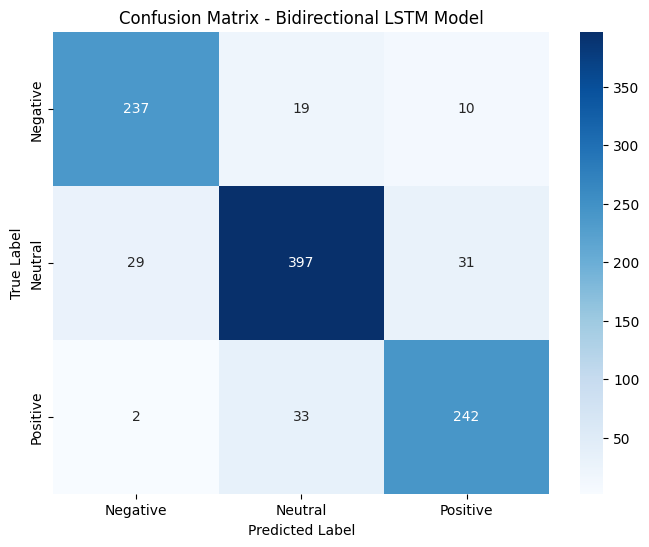

Classification Report - Bidirectional LSTM Model:
              precision    recall  f1-score   support

    Negative       0.88      0.89      0.89       266
     Neutral       0.88      0.87      0.88       457
    Positive       0.86      0.87      0.86       277

    accuracy                           0.88      1000
   macro avg       0.87      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [74]:
# Generate predictions for confusion matrix and classification report
y_val_pred = model.predict(val_ds)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(val_labels, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Bidirectional LSTM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("Classification Report - Bidirectional LSTM Model:")
print(classification_report(val_labels, y_val_pred_classes, 
                          target_names=['Negative', 'Neutral', 'Positive']))


It takes a lot more computational effort (time and money) and it doesnt yield better results than our 1D convolutional network.

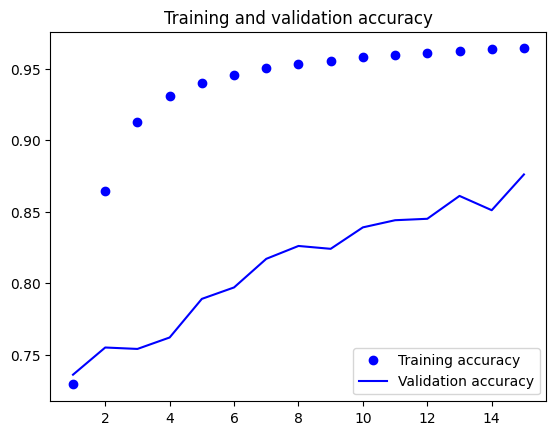

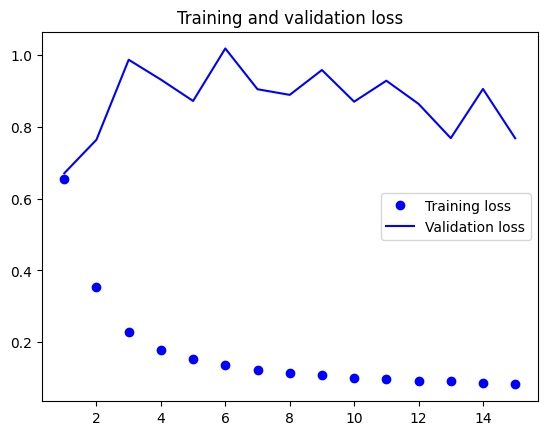

In [75]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We get a final validation accuracy of around 85%. 

Lets try using transformers

## Transformers

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


# Special format for tokenization
def encode(texts, max_len=128):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf",
    )


train_encodings = encode(list(train_texts))
val_encodings = encode(list(val_texts))

train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(train_encodings), train_labels)
).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(val_encodings), val_labels)
).batch(32)

In [ ]:
print(tokenizer.decode(tokenizer(train_texts[0])["input_ids"]))

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Lambda
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")


# Wrap the call to BERT in a Lambda layer
def extract_bert_cls(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    return outputs.last_hidden_state[:, 0, :]  # CLS token (batch_size, hidden_size)


cls_output = Lambda(extract_bert_cls, output_shape=(768,))([input_ids, attention_mask])

x = Dropout(0.3)(cls_output)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.fit(train_dataset, validation_data=val_dataset, epochs=5)

This approach is very computationally expensive and doesn't really benefit from the power of Transformers. Our data, tweets, are very short texts and transformers really shine in long documents.